# Preambule

In [1]:
library(parallel)
library(caret)
library(data.table)
library(stringr)
library(scales)
library(dplyr)
library(randomForest)
library(RRF)
library(clustermq)
library(DALEX)
library('iBreakDown')
library(qs)
library(ggbeeswarm)
library(ggpubr)

Loading required package: lattice

Loading required package: ggplot2


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


Registered S3 method overwritten by 'RRF':
  method      from        
  plot.margin randomForest

RRF 1.9.1

Type rrfNews() to see new features/changes/bug fixes.


Attaching package: ‘RRF’


The following objects are masked from ‘package:randomForest’:

    classCenter, combine, getTree, grow, importance, margin, MDSplot,
    na.roughfix, outlier, partialPlot, treesize, varImpPlot, varUse

In [2]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects/Methanogen_SCFA/Metagenomes_methanogen/envs/r-ml/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggpubr_0.4.0        ggbeeswarm_0.6.0    qs_0.23.4          
 [4] iBreakDown_1.3.1    DALEX_2.0.1         clustermq_0.8.95.1 
 [7] RRF_1.9.1           randomForest_4.6-14 dplyr_1.0.2        
[10] scales_1.1.1        stringr_1.4.0       data.table_1.13.4

In [3]:
options(clustermq.scheduler = "sge", clustermq.template = "~/.clustermq.tmpl")

# Data

In [4]:
taxa <- qread('../data/taxa_table.qs')
pp <- qread('../data/tax_meta.qs')

In [5]:
# remove the MetaCyc pathways
to_rm <- seq(pp %>% colnames %>% str_which(pattern = '^[:lower:]\\_{1}') %>% max, ncol(pp), 1)
pp <- pp[,-to_rm]
pp %>% dim

[1] 2147 2513

In [6]:
# remove the metadata
meta <- c('dataset_name','Sample','age','gender','country','BMI','westernized')
X <- select(pp, -all_of(meta))

In [7]:
# keep only taxa with prevalance > 24%
tmp <- colnames(X)[which(colSums(X != 0) > nrow(X)/4)]
X <- select(X, all_of(tmp))
X %>% dim

[1] 2147  520

In [8]:
# shuffle samples
set.seed(0)
X <- X[complete.cases(X),][sample(1:nrow(X)),]

# Make the target

In [9]:
# draw random variables for predicting groups
set.seed(1209)
var_ix <- sample(which(colSums(X != 0) > nrow(X)/2), 9, replace = FALSE)
var_n <- colnames(X)[var_ix]

In [10]:
var_n

[1] "s_Marvinbryantia_sp900066075"     "g_Alistipes_A"                   
[3] "f_Bacteroidaceae"                 "g_Dialister"                     
[5] "s_Oscillibacter_sp001916835"      "s_Bacteroides_clarus"            
[7] "s_Faecalibacterium_prausnitzii_G" "s_Lawsonibacter_sp000177015"     
[9] "f_Anaerovoracaceae"

In [11]:
nr <- nrow(X)
ng <- floor(nr/4)
# make groups
X <- as.data.table(X)[,'group':=c(rep('a',ng), rep('b', ng), rep('c', ng), rep('d', nr-3*ng))]

In [12]:
target <- data.frame('group'= X$group, 'tc'='1', stringsAsFactors = FALSE)

In [13]:
# for each group, make target according to random drawn taxa of var_n
target$tc[target$group == 'a'] <- ifelse( X$s_Marvinbryantia_sp900066075[target$group == 'a'] > 0 
                                         & X$g_Alistipes_A[target$group == 'a'] > 0 
                                         , '1', '-1')
target$tc[target$group == 'b'] <- ifelse( X$f_Bacteroidaceae[target$group == 'b'] > 10^-(1) 
                                         & X$g_Dialister[target$group == 'b'] > 10^-(2.5)
                                         , '1', '-1')
target$tc[target$group == 'c'] <- ifelse((X$s_Oscillibacter_sp001916835[target$group == 'c'] > 0 
                                         & X$s_Bacteroides_clarus[target$group == 'c'] > 0)
                                         | X$s_Faecalibacterium_prausnitzii_G[target$group == 'c'] >10^-2
                                         , '1', '-1')
target$tc[target$group == 'd'] <- ifelse( X$s_Lawsonibacter_sp000177015[target$group == 'd'] <= 10^-3.4 
                                         & X$f_Anaerovoracaceae[target$group == 'd'] > 0
                                         , '1', '-1')

In [14]:
table(target$tc, target$group)

    
       a   b   c   d
  -1 319 299 214 361
  1  217 237 322 178

In [15]:
# randomise group labels
groups <- c('a', 'b', 'c', 'd', 'e')
set.seed(0)
brnounou <- rbinom(n = length(X$group), size = 1,prob = 0.05)
for (i in 1:length(brnounou)){
    if (brnounou[i] == 1){
        set.seed(i)
        X$group[i] <- sample(groups[groups != X$group[i]], 1)
    }
}

In [16]:
table(target$tc, X$group)

    
       a   b   c   d   e
  -1 312 296 226 347  12
  1  219 232 318 175  10

# Model

In [19]:
target_c <- as.factor(target$tc)
X <- X[, 'group':= as.factor(group)]

In [20]:
# transform to dummy
dummies <- dummyVars(~ ., data = X )
dummies <- as.data.table(predict(dummies, newdata = X ))

In [21]:
colnames(dummies) <- colnames(dummies) %>% str_replace_all(pattern = '\\.', replacement ='')

In [17]:
gamma <- 0.45

In [22]:
set.seed(0)
message('Feature selection')
RF <- RRF(dummies, flagReg=0, as.factor(target_c))
imp <-RF$importance[,"MeanDecreaseGini"]
impRF <- (imp - min(imp))/(max(imp) - min(imp))# normalization
coefReg <- (1-gamma) + gamma*impRF
GRRF <- RRF(dummies, as.factor(target_c), flagReg=1, coefReg=coefReg)

Feature selection



In [23]:
# select data
to_keep <- colnames(dummies)[GRRF$feaSet]
X_fs <- select(dummies, all_of(to_keep))

In [24]:
# RF
set.seed(0)
rf_fs <- randomForest(x = X_fs, y = as.factor(target_c), ntree = 500)

In [33]:
rf_fs
cat('RF accuracy = ', 100*round((rf_fs$confusion[1,1] + rf_fs$confusion[2,2])/sum(rf_fs$confusion), digits = 4))


Call:
 randomForest(x = X_fs, y = as.factor(target_c), ntree = 500) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 6.66%
Confusion matrix:
     -1   1 class.error
-1 1145  48  0.04023470
1    95 859  0.09958071

RF accuracy =  93.33

# get SHAP values

In [25]:
explain_rf <- DALEX::explain( model = rf_fs, data = X_fs, y = target_c == "1")

Preparation of a new explainer is initiated
  -> model label       :  randomForest  (  default  )
  -> data              :  2147  rows  18  cols 
  -> target variable   :  2147  values 
  -> predict function  :  yhat.randomForest  will be used (  default  )
  -> predicted values  :  numerical, min =  0 , mean =  0.4426716 , max =  0.998  
  -> model_info        :  package randomForest , ver. 4.6.14 , task classification (  default  ) 
  -> model_info        :  Model info detected classification task but 'y' is a logical . Converted to numeric.  (  NOTE  )
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -0.356 , mean =  0.001669306 , max =  0.374  
  A new explainer has been created!  


In [26]:
listed_data <- lapply(seq_len(nrow(X_fs)), function(i) X_fs[i,]) %>% as.list

In [27]:
### Modify the DALEX function: silence the initial check
shap_bab <- function(new_observation, explain_rf) {
  # call the shap from iBreakDown
  res <- iBreakDown::shap(x = explain_rf, new_observation = new_observation)
  class(res) <- c('predict_parts', class(res))
  return(res)
}

In [28]:
tmpl <- list(conda = "r-ml", cores = 3, job_time = '00:59:00', job_mem = '1G')

In [ ]:
shap_1000 <- Q(shap_bab
               , new_observation = listed_data
               , const=list(explain_rf = explain_rf)
               , n_jobs= length(listed_data)
               , pkgs=c('iBreakDown', 'DALEX', 'randomForest')
               , log_worker=FALSE
               , template = tmpl
 )

# format results

In [30]:
formatSingleSHAP <- function(i, res){
    res <- res[[i]] %>% select(variable_name, variable_value, contribution) %>% 
                group_by(variable_name, variable_value) %>% summarise_all(mean) %>% 
                ungroup()
    res$sample <- i
    return(res)
    
}

In [31]:
res <-lapply(1:length(shap_1000), formatSingleSHAP, res = shap_1000) 

In [32]:
res <- as.data.frame(do.call(rbind, res))

In [33]:
res$contribution <- as.numeric(res$contribution)
res$variable_value <- as.numeric(res$variable_value)

In [34]:
resM <- res %>% group_by(variable_name) %>% 
    summarise(shapM = mean(abs(contribution)), shapS = sum(abs(contribution)))

`summarise()` ungrouping output (override with `.groups` argument)



In [35]:
resM$variable_name <- factor(resM$variable_name
                             , levels = resM$variable_name[order(resM$shapM)])

# plots

## all

In [36]:
res %>% colnames

[1] "variable_name"  "variable_value" "contribution"   "sample"

In [37]:
range01 <- function(x){ 
        # change the zeros to get nicer log10 plots
        mini <- min(x[x > 0]) 
        mini <- mini - mini/10
        x[x == 0] <- mini
        
        x <- log10(x)
    (x - min(x))/(max(x) - min(x))
}

In [39]:
res01 <- res %>% group_by(variable_name) %>% summarise(value01 = range01(variable_value)
                                              , variable_value = variable_value
                                              , contribution=contribution
                                              , sample=sample
                                             ) 

`summarise()` regrouping output by 'variable_name' (override with `.groups` argument)



In [40]:
res01 %>% summary

 variable_name         value01       variable_value     contribution      
 Length:38646       Min.   :0.0000   Min.   :0.00000   Min.   :-0.295475  
 Class :character   1st Qu.:0.0000   1st Qu.:0.00000   1st Qu.:-0.022041  
 Mode  :character   Median :0.2678   Median :0.00057   Median : 0.002295  
                    Mean   :0.3192   Mean   :0.07554   Mean   : 0.000000  
                    3rd Qu.:0.5522   3rd Qu.:0.00585   3rd Qu.: 0.022885  
                    Max.   :1.0000   Max.   :1.00000   Max.   : 0.290248  
     sample    
 Min.   :   1  
 1st Qu.: 537  
 Median :1074  
 Mean   :1074  
 3rd Qu.:1611  
 Max.   :2147  

In [41]:
shapM_plot <- ggplot(resM, aes(x=variable_name, y=shapM))+
geom_col(fill = 'gray', width = .1) + 
geom_point(shape  = 21, color = 'black', size = 3) + coord_flip() + 
theme_classic()+
labs(y = 'mean(|SHAP|) value', x='', title = 'p = 0.05')+
coord_flip()+
theme(panel.grid.major.y = element_line(colour = "grey", size = .2)
      , legend.text = element_text(size = rel(1.2))
      , legend.position = 'left'
      ,axis.text.y = element_text(size = rel(1.3)) ) 

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



In [42]:
# order the variables for the next plot
res$variable_name <- factor(res$variable_name
                             , levels = resM$variable_name[order(resM$shapM)])
res01$variable_name <- factor(res01$variable_name
                             , levels = resM$variable_name[order(resM$shapM)])

In [43]:
shap_plot <- ggplot(res01, aes(y=variable_name, x=contribution, color=value01))+

geom_vline(xintercept = 0, color = 'lightgrey')+
theme_classic()+
theme(panel.grid.major.y = element_line(colour = "grey", size = .2)
      , legend.text = element_text(size = rel(1.2))
      , legend.title = element_text(size = rel(1.2))
      , legend.position = 'right'
      , axis.text.y = element_blank() ) +
scale_color_gradient(low = 'dodgerblue', high = 'deeppink2', name = 'Variable value\n(log10)', 
                     , breaks = c(0.05, 0.95)
                     , labels = c('min', 'max')
                    )+
labs(x = 'SHAP value', y='', title = 'p = 0.05')+
geom_quasirandom(groupOnX = FALSE, alpha = .25, size = .05)

In [44]:
shap_global <- ggarrange(shapM_plot, shap_plot, ncol = 2, nrow = 1)

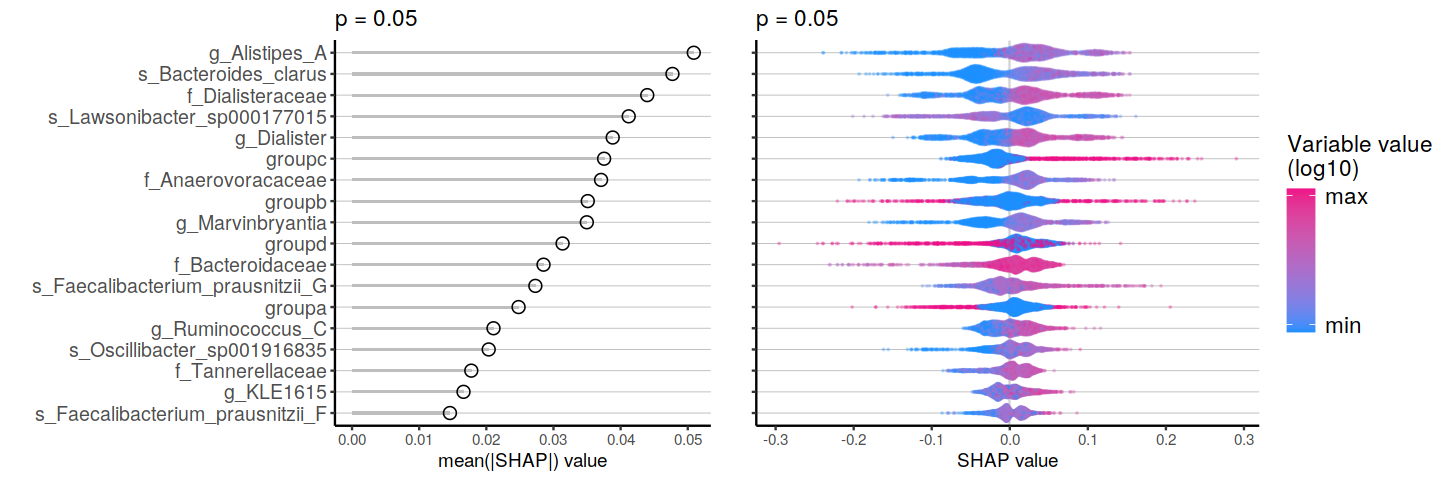

In [45]:
options(repr.plot.width=12, repr.plot.height=4)
shap_global

## shap per group for each variable

In [46]:
plot_v <- function(res, v_name, g_names){
    # create the tmp data
    tmp <- subset(res, variable_name == v_name)
    for (g in g_names){
        tmp$tmp <- res$variable_value[res$variable_name == g]
        colnames(tmp)[colnames(tmp) == 'tmp'] <- g
    }
    
    # change the zeros to get nicer log10 plots
    mini <- min(tmp$variable_value[tmp$variable_value > 0]) 
    mini <- mini - mini/10
    tmp$variable_value[tmp$variable_value == 0] <- mini
    
    res_p <- list()
    xn <- str_replace_all(v_name, pattern = '_', replacement = ' ') %>%
            str_replace_all(pattern = '^[:lower:]\\s', replacement = '')
    
    for (g in g_names){
        res_p[[g]] <- ggplot(tmp, aes_string(x="log10(variable_value)", y="contribution", color = g))+
        geom_hline(yintercept = 0, color = 'darkgrey')+
        geom_point(alpha = .2)+
        theme_classic()+
        scale_color_gradient(low = 'dodgerblue', high = 'deeppink2', name = 'variable value'
                    , breaks = c(0.05, 0.95), labels = c('min', 'max'))+
        labs(x = paste0(xn, ' RA (log10)'), y='SHAP value', title = paste0(xn, ' - ', g))
    }
    
    return(res_p)
    
}

In [47]:
tnames <- unique(res$variable_name)
tnames <- tnames[!(tnames %in% c('groupa', 'groupb', 'groupc', 'groupd'))]
taxa_shap <- lapply(tnames, plot_v, res=res, g_names = c('groupa','groupb', 'groupc', 'groupd') )

In [48]:
for (i in 1:length(taxa_shap)){
    taxa_shap[[i]] <- ggarrange(plotlist = taxa_shap[[i]]
                                 , ncol = length(taxa_shap[[i]]), nrow = 1
                                , legend = 'right', common.legend = TRUE)
}

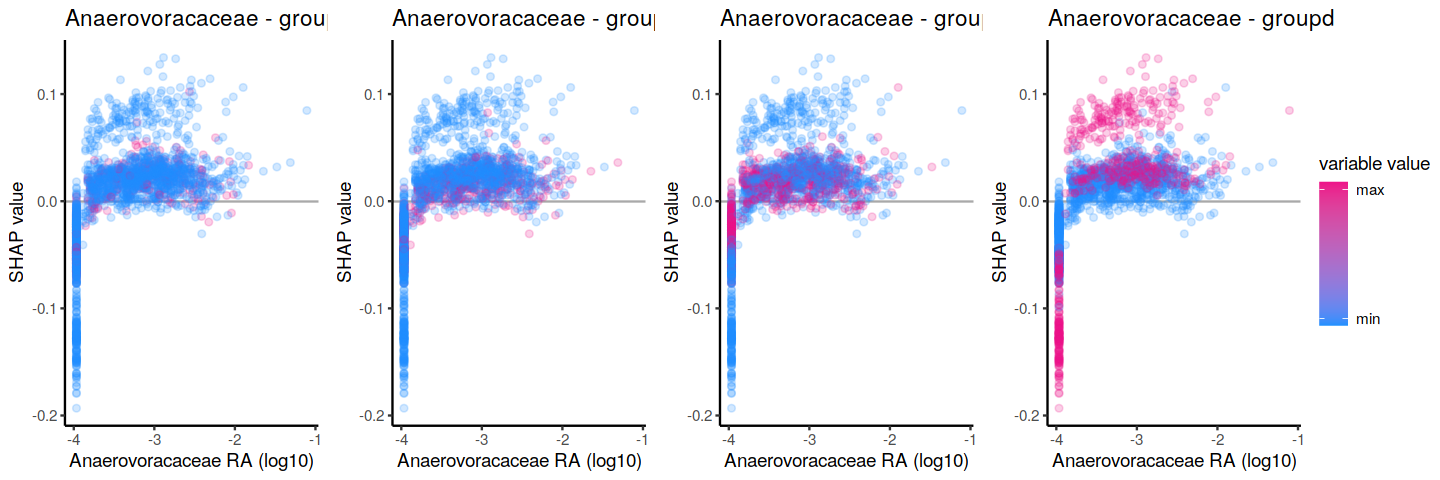

In [52]:
options(repr.plot.width=12, repr.plot.height=4)
# plot the 1st variable
taxa_shap[[1]]